In [381]:
# import libraries
import json
from pprint import pprint
from pandas.io.json import json_normalize
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, sys, glob
import matplotlib
import math
import random
from keras.optimizers import Optimizer
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger, TensorBoard, TerminateOnNaN
from keras.applications.vgg19 import VGG19
from keras import backend as K
from keras.legacy import interfaces
from keras.models import Model
from keras.layers.merge import Concatenate
from keras.layers import Activation, Input, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Multiply
from keras.regularizers import l2
from keras.initializers import random_normal, constant
import re


%matplotlib inline

## coco person keypoints json file

In [8]:
# explore the person keypoints json file associated with the coco 2017 dataset
keypoints_train = json.load(open('./dataset/annotations/person_keypoints_train2017.json'))
keypoints_val = json.load(open('./dataset/annotations/person_keypoints_val2017.json'))

In [9]:
keypoints_train.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [24]:
df_train_category = json_normalize(keypoints_train['categories'])
skeleton = df_train_category['skeleton'][0]
KPs = df_train_category['keypoints'][0]

In [117]:
df_train_image = json_normalize(keypoints_train['images'])
df_train_annotation = json_normalize(keypoints_train['annotations'])
df_val_image = json_normalize(keypoints_val['images'])
df_val_annotation = json_normalize(keypoints_val['annotations'])

In [118]:
# print the number of labeled object in the train and validation dataset
print ("the number of data objects in the trainging set is %6.2d." % df_train_annotation.shape[0])
print ("the number of data objects in the validation set is %6.2d." % df_val_annotation.shape[0])
# print the number of images in the train and validation dataset
print ("\nthe number of images in the trainging set is %6.2d." % df_train_annotation['image_id'].unique().shape[0])
print ("the number of images in the validation set is %6.2d." % df_val_annotation['image_id'].unique().shape[0])

the number of data objects in the trainging set is 262465.
the number of data objects in the validation set is  11004.

the number of images in the trainging set is  64115.
the number of images in the validation set is   2693.


In [119]:
# merge the image and annotation table on image_id
df_train_image = df_train_image.rename(index=str, columns={"id": "image_id"})
df_train_image = pd.merge(df_train_image, df_train_annotation, on='image_id', how='left')
df_val_image = df_val_image.rename(index=str, columns={"id": "image_id"})
df_val_image = pd.merge(df_val_image, df_val_annotation, on='image_id', how='left')

In [122]:
# extract the relevant information based on the number of visible human key-points
keypoints_thredhold = 16
df_train_raw = df_train_image[(df_train_image['num_keypoints']>keypoints_thredhold)][['file_name','height','image_id','width','bbox','keypoints',\
                                                                      'num_keypoints','segmentation']].reset_index(drop=True)
df_val = df_val_image[df_val_image['num_keypoints']>keypoints_thredhold][['file_name','height','image_id','width','bbox','keypoints',\
                                                                      'num_keypoints','segmentation']].reset_index(drop=True)

In [275]:
640/480*220

293.3333333333333

In [123]:
df_train_raw

file_name  height  image_id  width  \
0     000000574769.jpg     640    574769    480   
1     000000483108.jpg     640    483108    428   
2     000000372938.jpg     424    372938    640   
3     000000515289.jpg     640    515289    639   
4     000000515289.jpg     640    515289    639   
5     000000321107.jpg     480    321107    269   
6     000000459912.jpg     427    459912    640   
7     000000170629.jpg     431    170629    640   
8     000000170629.jpg     431    170629    640   
9     000000455859.jpg     480    455859    640   
10    000000327807.jpg     480    327807    640   
11    000000231163.jpg     400    231163    640   
12    000000578292.jpg     640    578292    480   
13    000000046743.jpg     640     46743    480   
14    000000109819.jpg     480    109819    640   
15    000000109819.jpg     480    109819    640   
16    000000511204.jpg     640    511204    453   
17    000000260166.jpg     480    260166    640   
18    000000260166.jpg     480    260166    640   
19    000000139530.jpg     469    139530    640   
20    000000103579.jpg     427    103579    640   
21    000000103579.jpg     427    103579    640   
22    000000517822.jpg     640    517822    429   
23    000000016574.jpg     359     16574    640   
24    000000511117.jpg     640    511117    480   
25    000000098590.jpg     478     98590    640   
26    000000098590.jpg     478     98590    640   
27    000000098590.jpg     478     98590    640   
28    000000536831.jpg     480    536831    640   
29    000000138975.jpg     480    138975    640   
...                ...     ...       ...    ...   
8445  000000010358.jpg     640     10358    478   
8446  000000086620.jpg     423     86620    640   
8447  000000035245.jpg     423     35245    640   
8448  000000411399.jpg     426    411399    640   
8449  000000075800.jpg     480     75800    640   
8450  000000075800.jpg     480     75800    640   
8451  000000121792.jpg     486    121792    640   
8452  000000142208.jpg     640    142208    427   
8453  000000326354.jpg     333    326354    500   
8454  000000326354.jpg     333    326354    500   
8455  000000429182.jpg     207    429182    500   
8456  000000122527.jpg     427    122527    640   
8457  000000122527.jpg     427    122527    640   
8458  000000119087.jpg     640    119087    480   
8459  000000456545.jpg     629    456545    640   
8460  000000456545.jpg     629    456545    640   
8461  000000389935.jpg     480    389935    640   
8462  000000031358.jpg     427     31358    640   
8463  000000025801.jpg     640     25801    427   
8464  000000271941.jpg     427    271941    640   
8465  000000295778.jpg     640    295778    559   
8466  000000247397.jpg     427    247397    640   
8467  000000053729.jpg     480     53729    640   
8468  000000327758.jpg     428    327758    640   
8469  000000232467.jpg     640    232467    480   
8470  000000060136.jpg     480     60136    640   
8471  000000198042.jpg     427    198042    640   
8472  000000426975.jpg     427    426975    640   
8473  000000094714.jpg     640     94714    427   
8474  000000545549.jpg     480    545549    640   

                                  bbox  \
0     [103.32, 133.45, 231.03, 421.89]   
1      [198.61, 343.72, 93.15, 209.79]   
2      [192.83, 167.66, 86.75, 167.84]   
3       [248.69, 0.84, 129.44, 313.52]   
4       [111.25, 19.05, 90.68, 213.18]   
5      [152.48, 77.42, 104.16, 191.14]   
6        [16.35, 87.03, 61.55, 125.03]   
7       [23.14, 194.31, 69.28, 203.95]   
8       [78.25, 201.08, 50.31, 159.61]   
9       [153.26, 102.65, 87.02, 215.7]   
10         [209.41, 182.62, 54, 138.5]   
11      [33.57, 239.92, 44.56, 107.48]   
12    [153.89, 327.91, 146.69, 281.89]   
13     [97.58, 216.85, 212.38, 298.47]   
14      [217.8, 223.45, 73.51, 129.95]   
15      [495.87, 218.48, 59.75, 162.1]   
16       [175.88, 24.7, 99.31, 131.55]   
17      [238.55, 171.67, 37.16, 89.43]   
18      [320.82, 98.98, 51.95, 143.75]   
19     [25

In [124]:
# print the number of labeled object in the train and validation dataset
print ('After data filtration by removing the non-human objects and images\n')
print ("the number of data objects in the trainging set is %6.2d." % df_train_raw.shape[0])
print ("the number of data objects in the validation set is %6.2d." % df_val.shape[0])
# print the number of images in the train and validation dataset
print ("\nthe number of images in the trainging set is %6.2d." % df_train_raw['image_id'].unique().shape[0])
print ("the number of images in the validation set is %6.2d." % df_val['image_id'].unique().shape[0])

After data filtration by removing the non-human objects and images

the number of data objects in the trainging set is   8475.
the number of data objects in the validation set is    336.

the number of images in the trainging set is   6833.
the number of images in the validation set is    262.


In [125]:
df_train = df_train_raw.sample(frac=1.00).reset_index()
df_test = df_train_raw.sample(frac=0.1).reset_index()

In [126]:
# print the number of labeled object in the train and validation dataset
print ('Subsampling\n')
print ("the number of data objects in the trainging set is %6.2d." % df_train.shape[0])
print ("the number of data objects in the validation set is %6.2d." % df_val.shape[0])
print ("the number of data objects in the test set is %6.2d." % df_test.shape[0])
# print the number of images in the train and validation dataset
print ("\nthe number of images in the trainging set is %6.2d." % df_train['image_id'].unique().shape[0])
print ("the number of images in the validation set is %6.2d." % df_val['image_id'].unique().shape[0])
print ("the number of images in the test set is %6.2d." % df_test['image_id'].unique().shape[0])

Subsampling

the number of data objects in the trainging set is   8475.
the number of data objects in the validation set is    336.
the number of data objects in the test set is    848.

the number of images in the trainging set is   6833.
the number of images in the validation set is    262.
the number of images in the test set is    823.


In [127]:
# find the text after a first string
def find_after( s, first):
    try:
        start = s.index( first ) + len( first )
        #end = s.index( last, start )
        return s[start:]
    except ValueError:
        return ""

In [363]:
Raw_images = []
file_path = []
for i in df_train['file_name']:
    file = './dataset/train2017/' + i 
    file_path.append(file)

In [129]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

In [133]:
img = cv2.imread(file_path[m])

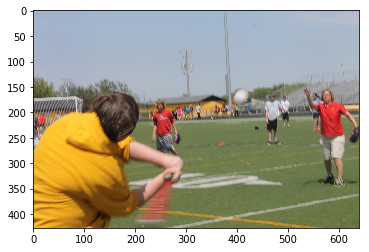

In [135]:
plt.imshow(img[:,:,::-1])

## Data propration and augmentation on the fly

In [527]:
def Gaussian2d(x, y, x0, y0, a, sigma=10):
    xx = (float(x) - x0)** 2 / 2 / sigma **2
    yy = (float(y) - y0)** 2 / 2 / sigma **2
    return a * math.exp(- xx - yy)


def generator(batch_size):
    n_record = len(df_train)
    # Create empty arrays to contain batch of features and labels
    batch_features = np.zeros((batch_size, 220, 300, 3))
    batch_labels = np.zeros((batch_size, 27, 37, 17))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index= random.randint(0,n_record)
            img = cv2.imread(file_path[index])
            # create one layer for each of labeled part
            w,h = img.shape[0], img.shape[1]
            heat_map = create_labels(img, df_train['keypoints'][index])
            process_img = img_processing(img)
            batch_features[i] = process_img
            batch_labels[i] = heat_map
        print ("batch feed step done")
        print (batch_features[0].shape)
        print (batch_labels[0].shape)
        yield batch_features, batch_labels

        
def img_processing(img):
    # data processing and data augumentation
    # TODO, data augmentation
    img = img/255. - 0.5
    img = cv2.resize(img,(300, 220),interpolation=cv2.INTER_CUBIC)
    return img
    

def create_labels(img, points):
    # assume the raw images will be resized in to (220, 300)
    # the heat_map will be in the size of (27,37)
    w, h = img.shape[0], img.shape[1]
    heat_map_raw = np.zeros((w, h, 17))
    radius = 50
    for i in range (17):
        if points[i*3+2] == 2:
            x0,y0 = points[i*3+1], points[i*3]
            for x in range (x0-radius, x0+radius):
                for y in range (y0-radius, y0+radius ):
                    if x in range (0,w) and y in range (0,h):
                        heat_map_raw[x, y, i] = Gaussian2d(x,y, x0,y0, 1, 10)
    heat_map = cv2.resize(heat_map_raw, (37,27),interpolation=cv2.INTER_CUBIC)

    return heat_map

Using TensorFlow backend.


In [511]:
def relu(x): 
    return Activation('relu')(x)

def conv(x, nf, ks, name, weight_decay):
    kernel_reg = l2(weight_decay[0]) if weight_decay else None
    bias_reg = l2(weight_decay[1]) if weight_decay else None

    x = Conv2D(nf, (ks, ks), padding='same', name=name,
               kernel_regularizer=kernel_reg,
               bias_regularizer=bias_reg,
               kernel_initializer=random_normal(stddev=0.01),
               bias_initializer=constant(0.0))(x)
    return x

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x, weight_decay):
    # Block 1
    x = conv(x, 64, 3, "conv1_1", (weight_decay, 0))
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2", (weight_decay, 0))
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1", (weight_decay, 0))
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2", (weight_decay, 0))
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")

    # Block 3
    x = conv(x, 256, 3, "conv3_1", (weight_decay, 0))
    x = relu(x)
    x = conv(x, 256, 3, "conv3_2", (weight_decay, 0))
    x = relu(x)
    x = conv(x, 256, 3, "conv3_3", (weight_decay, 0))
    x = relu(x)
    x = conv(x, 256, 3, "conv3_4", (weight_decay, 0))
    x = relu(x)
    x = pooling(x, 2, 2, "pool3_1")

    # Block 4
    x = conv(x, 512, 3, "conv4_1", (weight_decay, 0))
    x = relu(x)
    x = conv(x, 512, 3, "conv4_2", (weight_decay, 0))
    x = relu(x)

    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM", (weight_decay, 0))
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM", (weight_decay, 0))
    x = relu(x)

    return x


def stage1_block(x, num_p, branch, weight_decay):

    x = conv(x, 128, 3, "Mconv1_stage1_L%d" % branch, (weight_decay, 0))
    x = relu(x)
    x = conv(x, 128, 3, "Mconv2_stage1_L%d" % branch, (weight_decay, 0))
    x = relu(x)
    x = conv(x, 128, 3, "Mconv3_stage1_L%d" % branch, (weight_decay, 0))
    x = relu(x)
    x = conv(x, 512, 1, "Mconv4_stage1_L%d" % branch, (weight_decay, 0))
    x = relu(x)
    x = conv(x, num_p, 1, "Mconv5_stage1_L%d" % branch, (weight_decay, 0))

    return x


def stageT_block(x, num_p, stage, branch, weight_decay):

    x = conv(x, 128, 7, "Mconv1_stage%d_L%d" % (stage, branch), (weight_decay, 0))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch), (weight_decay, 0))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch), (weight_decay, 0))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch), (weight_decay, 0))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch), (weight_decay, 0))
    x = relu(x)
    x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch), (weight_decay, 0))
    x = relu(x)
    x = conv(x, num_p, 1, "Mconv7_stage%d_L%d" % (stage, branch), (weight_decay, 0))

    return x

def apply_mask(x, mask1, mask2, num_p, stage, branch, np_branch1, np_branch2):
    w_name = "weight_stage%d_L%d" % (stage, branch)

    # TODO: we have branch number here why we made so strange check
    assert np_branch1 != np_branch2 # we selecting branches by number of pafs, if they accidentally became the same it will be disaster

    if num_p == np_branch1:
        w = Multiply(name=w_name)([x, mask1])  # vec_weight
    elif num_p == np_branch2:
        w = Multiply(name=w_name)([x, mask2])  # vec_heat
    else:
        assert False, "wrong number of layers num_p=%d " % num_p
    return w

In [512]:
def get_training_model(weight_decay, np_branch2, stages = 6, gpus = None):

    img_input_shape = (None, None, 3)
    heat_input_shape = (None, None, np_branch2)

    inputs = []
    outputs = []

    img_input = Input(shape=img_input_shape)
    heat_weight_input = Input(shape=heat_input_shape)

    inputs.append(img_input)

    #inputs.append(heat_weight_input)

    #img_normalized = img_input # will be done on augmentation stage

    # VGG
    stage0_out = vgg_block(img_input, weight_decay)

    # stage 1
    new_x = []
    stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2, weight_decay)
    w = Multiply()([stage1_branch2_out, heat_weight_input])
    #w2 = apply_mask(stage1_branch2_out, vec_weight_input, heat_weight_input, np_branch2, 1, 2, np_branch1, np_branch2)
    outputs.append(stage1_branch2_out)
    new_x.append(stage1_branch2_out)

    new_x.append(stage0_out)

    x = Concatenate()(new_x)

#     # stage sn >= 2, repeating stage
#     for sn in range(2, stages + 1):

#         new_x = []
#         # stage T
#         stageT_branch2_out = stageT_block(x, np_branch2, sn, 2, weight_decay)
#         w = Multiply()([stageT_branch2_out, heat_weight_input])
#         #w2 = apply_mask(stageT_branch2_out, vec_weight_input, heat_weight_input, np_branch2, sn, 2, np_branch1, np_branch2)
#         outputs.append(stageT_branch2_out)
#         new_x.append(stageT_branch2_out)
#         new_x.append(stage0_out)

#         if sn < stages:
#             x = Concatenate()(new_x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def get_lrmult(model):

    # setup lr multipliers for conv layers
    lr_mult = dict()

    for layer in model.layers:

        if isinstance(layer, Conv2D):

            # stage = 1
            if re.match("Mconv\d_stage1.*", layer.name):
                kernel_name = layer.weights[0].name
                bias_name = layer.weights[1].name
                lr_mult[kernel_name] = 1
                lr_mult[bias_name] = 2

            # stage > 1
            elif re.match("Mconv\d_stage.*", layer.name):
                kernel_name = layer.weights[0].name
                bias_name = layer.weights[1].name
                lr_mult[kernel_name] = 4
                lr_mult[bias_name] = 8

            # vgg
            else:
               print("matched as vgg layer", layer.name)
               kernel_name = layer.weights[0].name
               bias_name = layer.weights[1].name
               lr_mult[kernel_name] = 1
               lr_mult[bias_name] = 2

    return lr_mult

## model training

In [513]:
batch_size = 10
base_lr = 2e-5
momentum = 0.9
weight_decay = 5e-4
lr_policy = "step"
gamma = 0.333
stepsize = 121746 * 17  # in original code each epoch is 121746 and step change is on 17th epoch
max_iter = 200

In [514]:
file_name = 'prelim_training'
date = '05072018'
file_id = file_name + "_" + date

WEIGHT_DIR = "./" + file_id
#WEIGHTS_SAVE = 'weights.{epoch:04d}.h5'

In [515]:
TRAINING_LOG = "./" + file_id + ".csv"
LOGS_DIR = "./logs"

model = get_training_model(weight_decay,np_branch2=17)
lr_mult = get_lrmult(model)

matched as vgg layer conv1_1
matched as vgg layer conv1_2
matched as vgg layer conv2_1
matched as vgg layer conv2_2
matched as vgg layer conv3_1
matched as vgg layer conv3_2
matched as vgg layer conv3_3
matched as vgg layer conv3_4
matched as vgg layer conv4_1
matched as vgg layer conv4_2
matched as vgg layer conv4_3_CPM
matched as vgg layer conv4_4_CPM


In [493]:
# Initialized the first 10 vgg layers using the pre-trained weights from vgg19

print("Loading vgg19 weights...")

vgg_model = VGG19(include_top=False, weights='imagenet')

from_vgg = dict()
from_vgg['conv1_1'] = 'block1_conv1'
from_vgg['conv1_2'] = 'block1_conv2'
from_vgg['conv2_1'] = 'block2_conv1'
from_vgg['conv2_2'] = 'block2_conv2'
from_vgg['conv3_1'] = 'block3_conv1'
from_vgg['conv3_2'] = 'block3_conv2'
from_vgg['conv3_3'] = 'block3_conv3'
from_vgg['conv3_4'] = 'block3_conv4'
from_vgg['conv4_1'] = 'block4_conv1'
from_vgg['conv4_2'] = 'block4_conv2'

Loading vgg19 weights...


In [494]:
for layer in model.layers:
    if layer.name in from_vgg:
        vgg_layer_name = from_vgg[layer.name]
        layer.set_weights(vgg_model.get_layer(vgg_layer_name).get_weights())
        print("Loaded VGG19 layer: " + vgg_layer_name)

Loaded VGG19 layer: block1_conv1
Loaded VGG19 layer: block1_conv2
Loaded VGG19 layer: block2_conv1
Loaded VGG19 layer: block2_conv2
Loaded VGG19 layer: block3_conv1
Loaded VGG19 layer: block3_conv2
Loaded VGG19 layer: block3_conv3
Loaded VGG19 layer: block3_conv4
Loaded VGG19 layer: block4_conv1
Loaded VGG19 layer: block4_conv2


In [516]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, None, None, 64)    1792      
_________________________________________________________________
activation_111 (Activation)  (None, None, None, 64)    0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, None, None, 64)    36928     
_________________________________________________________________
activation_112 (Activation)  (None, None, None, 64)    0         
_________________________________________________________________
pool1_1 (MaxPooling2D)       (None, None, None, 64)    0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, None, None, 128)   73856     
__________

In [518]:
last_epoch = 0

# euclidean loss as implemented in caffe https://github.com/BVLC/caffe/blob/master/src/caffe/layers/euclidean_loss_layer.cpp
def eucl_loss(x, y):
    l = K.sum(K.square(x - y)) / batch_size / 2
    return l

# learning rate schedule - equivalent of caffe lr_policy =  "step"
iterations_per_epoch = len(df_train) // batch_size

def step_decay(epoch):
    steps = epoch * iterations_per_epoch * batch_size
    lrate = base_lr * math.pow(gamma, math.floor(steps/stepsize))
    print("Epoch:", epoch, "Learning rate:", lrate)
    return lrate

print("Weight decay policy...")
for i in range(1,100,5): step_decay(i)

Weight decay policy...
Epoch: 1 Learning rate: 2e-05
Epoch: 6 Learning rate: 2e-05
Epoch: 11 Learning rate: 2e-05
Epoch: 16 Learning rate: 2e-05
Epoch: 21 Learning rate: 2e-05
Epoch: 26 Learning rate: 2e-05
Epoch: 31 Learning rate: 2e-05
Epoch: 36 Learning rate: 2e-05
Epoch: 41 Learning rate: 2e-05
Epoch: 46 Learning rate: 2e-05
Epoch: 51 Learning rate: 2e-05
Epoch: 56 Learning rate: 2e-05
Epoch: 61 Learning rate: 2e-05
Epoch: 66 Learning rate: 2e-05
Epoch: 71 Learning rate: 2e-05
Epoch: 76 Learning rate: 2e-05
Epoch: 81 Learning rate: 2e-05
Epoch: 86 Learning rate: 2e-05
Epoch: 91 Learning rate: 2e-05
Epoch: 96 Learning rate: 2e-05


In [519]:
# configure callbacks
lrate = LearningRateScheduler(step_decay)
checkpoint = ModelCheckpoint(WEIGHT_DIR + '/' + WEIGHTS_SAVE, monitor='loss', verbose=0, save_best_only=False, save_weights_only=True, mode='min', period=1)
csv_logger = CSVLogger(TRAINING_LOG, append=True)
tb = TensorBoard(log_dir=LOGS_DIR, histogram_freq=0, write_graph=True, write_images=False)
tnan = TerminateOnNaN()
#coco_eval = CocoEval(train_client, val_client)

callbacks_list = [lrate, checkpoint, csv_logger, tb, tnan]

In [520]:
class MultiSGD(Optimizer):
    """
    Modified SGD with added support for learning multiplier for kernels and biases
    as suggested in: https://github.com/fchollet/keras/issues/5920
    Stochastic gradient descent optimizer.
    Includes support for momentum,
    learning rate decay, and Nesterov momentum.
    # Arguments
        lr: float >= 0. Learning rate.
        momentum: float >= 0. Parameter updates momentum.
        decay: float >= 0. Learning rate decay over each update.
        nesterov: boolean. Whether to apply Nesterov momentum.
    """

    def __init__(self, lr=0.01, momentum=0., decay=0.,
                 nesterov=False, lr_mult=None, **kwargs):
        super(MultiSGD, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.momentum = K.variable(momentum, name='momentum')
            self.decay = K.variable(decay, name='decay')
        self.initial_decay = decay
        self.nesterov = nesterov
        self.lr_mult = lr_mult

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))
        # momentum
        shapes = [K.int_shape(p) for p in params]
        moments = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + moments
        for p, g, m in zip(params, grads, moments):

            if p.name in self.lr_mult:
                multiplied_lr = lr * self.lr_mult[p.name]
            else:
                multiplied_lr = lr

            v = self.momentum * m - multiplied_lr * g  # velocity
            self.updates.append(K.update(m, v))

            if self.nesterov:
                new_p = p + self.momentum * v - multiplied_lr * g
            else:
                new_p = p + v

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'momentum': float(K.get_value(self.momentum)),
                  'decay': float(K.get_value(self.decay)),
                  'nesterov': self.nesterov}
        base_config = super(MultiSGD, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [521]:
# sgd optimizer with lr multipliers
multisgd = MultiSGD(lr=base_lr, momentum=momentum, decay=0.0, nesterov=False, lr_mult=lr_mult)
# start training
model.compile(loss=eucl_loss, optimizer=multisgd)

In [529]:
# Do not run this block of code after debugging
# sequential training for debugging purpose
n_record = len(df_train)
# Create empty arrays to contain batch of features and labels
x = np.zeros((20, 220, 300, 3))
y = np.zeros((20, 27, 37, 17))

for i in range(20):
    # choose random index in features
    index= random.randint(0,n_record)
    img = cv2.imread(file_path[index])
    # create one layer for each of labeled part
    w,h = img.shape[0], img.shape[1]
    heat_map = create_labels(img, df_train['keypoints'][index])
    process_img = img_processing(img)
    x[i] = process_img
    y[i] = heat_map

model.fit(x,y,epochs=10, batch_size=32)

Epoch 1/10
20/20 [==============================] - 81s 4s/step - loss: 22.0414
Epoch 2/10


KeyboardInterrupt: 

In [530]:
model.fit_generator(generator(batch_size), steps_per_epoch = 100, epochs=max_iter, callbacks=callbacks_list)

Epoch: 0 Learning rate: 2e-05
Epoch 1/200
batch feed step done
(220, 300, 3)
(27, 37, 17)
batch feed step done
(220, 300, 3)
(27, 37, 17)
batch feed step done
(220, 300, 3)
(27, 37, 17)
batch feed step done
(220, 300, 3)
(27, 37, 17)


KeyboardInterrupt: 

In [ ]:
def get_testing_model(np_branch1, np_branch2, stages = 6):

    img_input_shape = (None, None, 3)

    img_input = Input(shape=img_input_shape)

    img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input) # [-0.5, 0.5]

    # VGG
    stage0_out = vgg_block(img_normalized, None)

    stages_out = []

    # stage 1 - branch 1 (PAF)
    if np_branch1 > 0:
        stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1, None)
        stages_out.append(stage1_branch1_out)

    # stage 1 - branch 2 (confidence maps)
    if np_branch2 > 0:
        stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2, None)
        stages_out.append(stage1_branch2_out)

    x = Concatenate()(stages_out + [stage0_out])

    # stage t >= 2
    stageT_branch1_out = None
    stageT_branch2_out = None
    for sn in range(2, stages + 1):

        stages_out = []

        if np_branch1 > 0:
            stageT_branch1_out = stageT_block(x, np_branch1, sn, 1, None)
            stages_out.append(stageT_branch1_out)
        if np_branch2 > 0:
            stageT_branch2_out = stageT_block(x, np_branch2, sn, 2, None)
            stages_out.append(stageT_branch2_out)

        if sn < stages:
            x = Concatenate()(stages_out + [stage0_out])

    model = Model(inputs=[img_input], outputs=[stageT_branch1_out, stageT_branch2_out])

    return model

In [ ]:
# below is the code copied from michalfaber's code on keypoints detection
weights_path = "model/keras/model.h5" # orginal weights converted from caffe
#weights_path = "training/weights.best.h5" # weights tarined from scratch 

input_shape = (None,None,3)

img_input = Input(shape=input_shape)

stages = 6
np_branch1 = 38
np_branch2 = 19

img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input)  # [-0.5, 0.5]

# VGG
stage0_out = vgg_block(img_normalized)

# stage 1
stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

# stage t >= 2
for sn in range(2, stages + 1):
    stageT_branch1_out = stageT_block(x, np_branch1, sn, 1)
    stageT_branch2_out = stageT_block(x, np_branch2, sn, 2)
    if (sn < stages):
        x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])

model = Model(img_input, [stageT_branch1_out, stageT_branch2_out])
model.load_weights(weights_path)

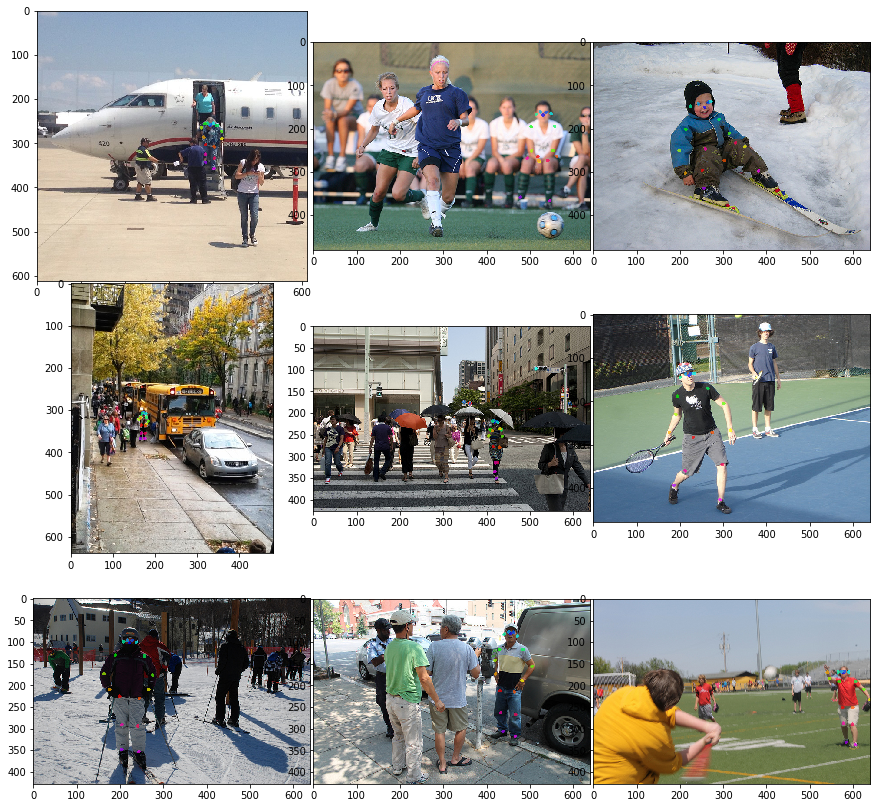

In [131]:
# scan the first nine raw images in the dataset
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
fig.subplots_adjust(wspace = .01, hspace = 0.01)
for k, ax in enumerate(axs.flatten()):
    #k = 5
    m = k+0
    canvas = cv2.imread(file_path[m]) # B,G,R order
    points= (df_train['keypoints'][m][::3],df_train['keypoints'][m][1::3])

    for i in range(0,17):
        rgba = np.array(cmap(1 - i/18. - 1./36))
        rgba[0:3] *= 255
        cv2.circle(canvas, (points[0][i], points[1][i]), 4, colors[i], thickness=-1)
    to_plot = cv2.addWeighted(Raw_images[m], 0.3, canvas, 0.7, 0)
    ax.imshow(to_plot[:,:,[2,1,0]])
    #ax = matplotlib.pyplot.gcf()
    #fig.set_size_inches(12, 12)
    
#fig.savefig('initial.png')

Plot the keypoints in the training dataset

In [154]:
k = 5
canvas = cv2.imread(file_path[k]) # B,G,R order
points= (df_train['keypoints'][k][::3],df_train['keypoints'][k][1::3])

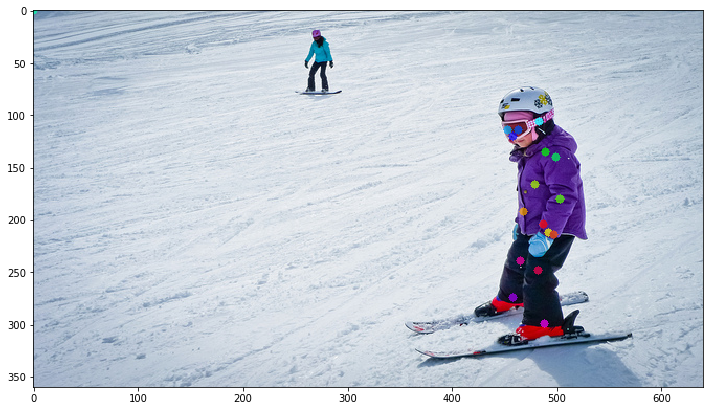

In [155]:
for i in range(0,17):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    cv2.circle(canvas, (points[0][i], points[1][i]), 4, colors[i], thickness=-1)
to_plot = cv2.addWeighted(Raw_images[k], 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

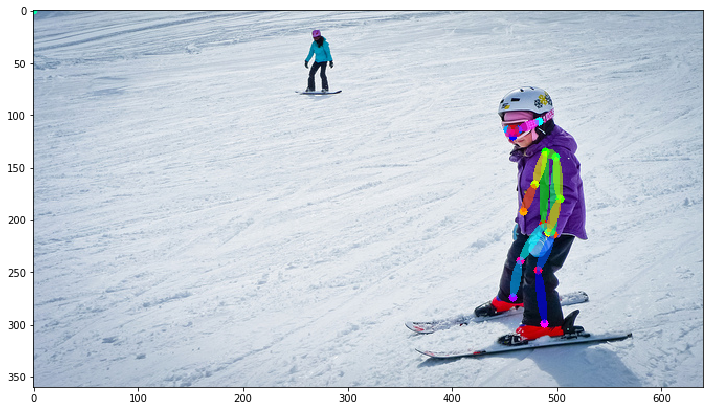

In [156]:
# visualize 2
stickwidth = 4

for i in range(17):
    Y1,X1 = points[0][[np.array(skeleton[i])-1][0][0]],points[1][[np.array(skeleton[i])-1][0][0]]
    Y2,X2 = points[0][[np.array(skeleton[i])-1][0][1]],points[1][[np.array(skeleton[i])-1][0][1]]
    if X1*Y1*X2*Y2==0:
        continue
    cur_canvas = canvas.copy()
    mX = np.mean([X1,X2])
    mY = np.mean([Y1,Y2])
    length = ((X1 - X2) ** 2 + (Y1 - Y2) ** 2) ** 0.5
    angle = math.degrees(math.atan2(X1 - X2, Y1 - Y2))
    polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
    cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
    canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

In [ ]:
# Load all the images in the test_img folder and save them in Raw_images
test_path = './train_2017/*.JPG'
files = glob.glob(test_path)
Raw_images = []
File_id = []
File_name = []
for file in files[500]:
    File_name.append(find_after(file, '\\'))
    image = cv2.imread(file)
    Raw_images.append(cv2.imread(file))

In [ ]:
# scan the first nine raw images in the dataset
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
fig.subplots_adjust(wspace = .01, hspace = 0.01)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(Raw_images[i][:,:,::-1])
    ax.axis("off")       
#fig.savefig('initial.png')

In [4]:
print ([str(i) for i in keypoints_val.keys()])
df_keypoints_val=json_normalize(keypoints_val['annotations'])
df_keypoints_val.head(100)

['info', 'licenses', 'images', 'annotations', 'categories']


area                              bbox  category_id      id  \
0    47803.27955    [73.35, 206.02, 300.58, 372.5]            1  183126   
1     1394.74310     [491.91, 183.51, 34.85, 73.4]            1  183302   
2      938.33980       [36.32, 0.59, 38.56, 53.86]            1  183830   
3    68822.32895     [276.35, 9.6, 244.69, 400.13]            1  184249   
4      485.51655      [97.1, 185.73, 28.66, 27.72]            1  184327   
5     5425.74330   [184.55, 45.56, 128.09, 255.34]            1  184382   
6     1040.20690     [79.58, 252.92, 24.11, 72.03]            1  184647   
7     1820.83745     [349.51, 189.48, 35.68, 93.9]            1  184742   
8    74885.91700      [134, 60.49, 373.08, 359.36]            1  184750   
9     1766.30760    [245.86, 163.37, 45.09, 67.19]            1  185180   
10     474.13985     [126.16, 221.8, 15.36, 58.49]            1  185291   
11     813.14000    [285.08, 192.33, 19.41, 97.06]            1  185550   
12    7355.75370   [252.06, 106.49, 66.17, 215.13]            1  185707   
13  119652.93175      [1.43, 2.39, 456.74, 409.96]            1  185727   
14   11063.38525   [243.23, 92.13, 140.99, 189.41]            1  186174   
15    7688.83320   [124.72, 202.25, 88.76, 220.22]            1  186234   
16     884.85075     [426.97, 90.43, 40.87, 80.39]            1  186602   
17    1428.25000             [54.5, 146.8, 37, 60]            1  186659   
18    3906.14190    [317.45, 116.23, 58.6, 110.13]            1  187195   
19    4336.88165   [275.58, 230.99, 57.63, 125.42]            1  187309   
20    1868.80435    [498.53, 107.59, 49.22, 95.59]            1  188069   
21    4296.17950    [197.31, 46.83, 79.08, 106.72]            1  188176   
22   16093.16355    [32.4, 122.05, 134.95, 313.95]            1  188349   
23    1240.82890    [290.19, 366.87, 41.13, 76.32]            1  188580   
24    2952.69460      [56.77, 24.77, 48.52, 90.84]            1  189711   
25    1881.04885      [353.34, 95.84, 34.2, 84.45]            1  190600   
26   59322.79120     [67.18, 17.95, 214.42, 386.5]            1  190623   
27   93478.39780         [0, 68.82, 330.32, 540.9]            1  190799   
28   17702.97795   [200.03, 232.57, 182.53, 270.8]            1  191310   
29   58215.36785     [45.06, 0.42, 317.21, 434.32]            1  191374   
..           ...                               ...          ...     ...   
70    3354.44800       [286.5, 0.72, 47.5, 228.72]            1  207041   
71    1761.32945    [283.68, 97.14, 40.07, 119.08]            1  207094   
72    8323.54715     [295.3, 230.2, 83.24, 242.66]            1  207891   
73   10938.47690     [235.75, 1.45, 78.67, 244.48]            1  208138   
74    5811.86520         [0, 5.76, 186.15, 151.61]            1  208369   
75    2050.99800     [322.26, 68.68, 31.87, 92.28]            1  208754   
76   11076.90365  [266.83, 217.03, 144.03, 249.42]            1  208842   
77    2137.10105     [64.24, 17.49, 45.26, 121.15]            1  209436   
78     632.83610    [217.68, 197.03, 18.59, 55.33]            1  209600   
79    3264.39280     [200.12, 17.02, 51.69, 93.82]            1  209661   
80   54516.36135     [1.44, 11.51, 243.05, 379.68]            1  209675   
81     124.03025    [446.73, 187.99, 11.97, 15.74]            1  210200   
82   74462.77670      [78.69, 8.92, 351.27, 346.4]            1  210632   
83    1706.97900   [265.82, 431.65, 44.85, 110.59]            1  210782   
84    1553.16375    [150.53, 121.98, 66.39, 90.85]            1  210931   
85    4380.20690    [140.12, 12.57, 45.11, 190.99]            1  211838   
86   11639.88610   [231.84, 233.37, 82.98, 258.69]            1  212268   
87    5519.15595    [281.77, 14.46, 97.93, 138.62]            1  212474   
88    9906.78990   [259.35, 60.66, 101.19, 156.46]            1  212792   
89   33639.45435     [44.22, 61.75, 242.7, 345.17]            1  212885   
90   19606.18910     [62.61, 48.59, 89.13, 322.69]            1  213188   
91    4009.35655   [361.97, 205.98, 5

In [24]:
print ([str(i) for i in json_normalize(keypoints_val['categories']).columns])

print ([str(i) for i in json_normalize(keypoints_val['images']).columns])

print ([str(i) for i in json_normalize(keypoints_val['info']).columns])

['id', 'keypoints', 'name', 'skeleton', 'supercategory']
['coco_url', 'date_captured', 'file_name', 'flickr_url', 'height', 'id', 'license', 'width']
['contributor', 'date_created', 'description', 'url', 'version', 'year']


In [25]:
print ([str(i) for i in json_normalize(keypoints_val['categories'])['skeleton'][0]])
print ([str(i) for i in json_normalize(keypoints_val['categories'])['keypoints'][0]])

['[16, 14]', '[14, 12]', '[17, 15]', '[15, 13]', '[12, 13]', '[6, 12]', '[7, 13]', '[6, 7]', '[6, 8]', '[7, 9]', '[8, 10]', '[9, 11]', '[2, 3]', '[1, 2]', '[1, 3]', '[2, 4]', '[3, 5]', '[4, 6]', '[5, 7]']
['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']


In [32]:
json_normalize(keypoints_val['images']).head()

coco_url        date_captured  \
0  http://images.cocodataset.org/val2017/00000039...  2013-11-14 17:02:52   
1  http://images.cocodataset.org/val2017/00000003...  2013-11-14 20:55:31   
2  http://images.cocodataset.org/val2017/00000025...  2013-11-14 22:32:02   
3  http://images.cocodataset.org/val2017/00000008...  2013-11-14 23:11:37   
4  http://images.cocodataset.org/val2017/00000017...  2013-11-14 23:16:55   

          file_name                                         flickr_url  \
0  000000397133.jpg  http://farm7.staticflickr.com/6116/6255196340_...   
1  000000037777.jpg  http://farm9.staticflickr.com/8429/7839199426_...   
2  000000252219.jpg  http://farm4.staticflickr.com/3446/3232237447_...   
3  000000087038.jpg  http://farm8.staticflickr.com/7355/8825114508_...   
4  000000174482.jpg  http://farm8.staticflickr.com/7020/6478877255_...   

   height      id  license  width  
0     427  397133        4    640  
1     230   37777        1    352  
2     428  252219        4    640  
3     480   87038        1    640  
4     388  174482        6    640

In [33]:
json_normalize(keypoints_val['licenses']).head()

id                                          name  \
0   1  Attribution-NonCommercial-ShareAlike License   
1   2             Attribution-NonCommercial License   
2   3    Attribution-NonCommercial-NoDerivs License   
3   4                           Attribution License   
4   5                Attribution-ShareAlike License   

                                                 url  
0  http://creativecommons.org/licenses/by-nc-sa/2.0/  
1     http://creativecommons.org/licenses/by-nc/2.0/  
2  http://creativecommons.org/licenses/by-nc-nd/2.0/  
3        http://creativecommons.org/licenses/by/2.0/  
4     http://creativecommons.org/licenses/by-sa/2.0/

In [34]:
json_normalize(keypoints_val['info']).head()

contributor date_created        description                     url  \
0  COCO Consortium   2017/09/01  COCO 2017 Dataset  http://cocodataset.org   

  version  year  
0     1.0  2017

## coco train2017 json file

In [38]:
captions_train2017 = json.load(open('./proj/annotations/captions_train2017.json'))
# pprint(data)
df_captions_train2017=json_normalize(captions_train2017['annotations'])
print captions_train2017.keys()
df_captions_train2017.head()

SyntaxError: invalid character in identifier (<ipython-input-38-122b921c361a>, line 4)

In [40]:
##############################################470MB
instances_train2017 = json.load(open('./proj/annotations/instances_train2017.json'))
# pprint(data)
df_instances_train2017=json_normalize(instances_train2017['annotations'])
df_instances_train2017.head()

area                             bbox  category_id    id  image_id  \
0  2765.14865   [199.84, 200.46, 77.71, 70.88]           58   156    558840   
1  1545.42130  [234.22, 317.11, 149.39, 38.55]           58   509    200365   
2  5607.66135   [239.48, 347.87, 160.0, 57.81]           58   603    200365   
3     0.00000      [296.65, 388.33, 1.03, 0.0]           58   918    200365   
4   800.41325  [251.87, 333.42, 125.94, 22.71]           58  1072    200365   

   iscrowd                                       segmentation  
0        0  [[239.97, 260.24, 222.04, 270.49, 199.84, 253....  
1        0  [[247.71, 354.7, 253.49, 346.99, 276.63, 337.3...  
2        0  [[274.58, 405.68, 298.32, 405.68, 302.45, 402....  
3        0  [[296.65, 388.33, 296.65, 388.33, 297.68, 388....  
4        0  [[251.87, 356.13, 260.13, 343.74, 300.39, 335....

In [59]:
instances_train2017.keys()

[u'info', u'licenses', u'images', u'annotations', u'categories']

In [76]:
json_normalize(instances_train2017['categories']).head()

id        name supercategory
0   1      person        person
1   2     bicycle       vehicle
2   3         car       vehicle
3   4  motorcycle       vehicle
4   5    airplane       vehicle

In [90]:
instances_val2017 = json.load(open('./proj/annotations/instances_val2017.json'))
# pprint(data)
df_instances_val2017=json_normalize(instances_val2017['annotations'])
print instances_val2017.keys()
df_instances_val2017.head()

[u'info', u'licenses', u'images', u'annotations', u'categories']


area                              bbox  category_id    id  \
0     702.10575    [473.07, 395.93, 38.65, 28.67]           18  1768   
1   27718.47630   [272.1, 200.23, 151.97, 279.77]           18  1773   
2   78969.31690  [124.71, 196.18, 372.85, 356.81]           18  2551   
3  108316.66515  [112.71, 154.82, 367.29, 479.35]           18  3186   
4   75864.53530   [200.61, 89.65, 400.22, 251.02]           18  3419   

   image_id  iscrowd                                       segmentation  
0    289343        0  [[510.66, 423.01, 511.72, 420.03, 510.45, 416....  
1     61471        0  [[289.74, 443.39, 302.29, 445.32, 308.09, 427....  
2    472375        0  [[147.76, 396.11, 158.48, 355.91, 153.12, 347....  
3    520301        0  [[260.4, 231.26, 215.06, 274.01, 194.33, 307.6...  
4    579321        0  [[200.61, 253.97, 273.19, 318.49, 302.43, 336....

In [89]:
image_info_test_dev2017=json.load(open('./proj/annotations 3/image_info_test-dev2017.json'))
# pprint(data)
df_image_info_test_dev2017=json_normalize(image_info_test_dev2017['categories'])
print image_info_test_dev2017.keys()
df_image_info_test_dev2017.head()

image_info_test2017=json.load(open('./proj/annotations 3/image_info_test2017.json'))
# pprint(data)
df_image_info_test2017=json_normalize(image_info_test_dev2017['categories'])
print image_info_test2017.keys()
df_image_info_test2017.head()

[u'info', u'images', u'licenses', u'categories']
[u'info', u'images', u'licenses', u'categories']


id        name supercategory
0   1      person        person
1   2     bicycle       vehicle
2   3         car       vehicle
3   4  motorcycle       vehicle
4   5    airplane       vehicle

## Data Exploration: first ~200 images in the validation set

In [5]:
# find the text after a first string
def find_after( s, first):
    try:
        start = s.index( first ) + len( first )
        #end = s.index( last, start )
        return s[start:]
    except ValueError:
        return ""

In [6]:
# Load all the images in the test_img folder and save them in Raw_images
test_path = './Test_img/*.JPG'
files = glob.glob(test_path)
Raw_images = []
File_id = []
File_name = []
for file in files:
    File_name.append(find_after(file, '\\'))
    image = cv2.imread(file)
    Raw_images.append(cv2.imread(file))

In [7]:
df_images_val = json_normalize(keypoints_val['images'])
df_category_val = json_normalize(keypoints_val['categories'])


In [15]:
df_category_val

id                                          keypoints    name  \
0   1  [nose, left_eye, right_eye, left_ear, right_ea...  person   

                                            skeleton supercategory  
0  [[16, 14], [14, 12], [17, 15], [15, 13], [12, ...        person

In [81]:
df_category_val.head()

id                                          keypoints    name  \
0   1  [nose, left_eye, right_eye, left_ear, right_ea...  person   

                                            skeleton supercategory  
0  [[16, 14], [14, 12], [17, 15], [15, 13], [12, ...        person

In [58]:
df_images.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [162]:
df_annotations_val = json_normalize(keypoints_val['annotations'])
df_annotations_val.head()

area                            bbox  category_id      id  image_id  \
0  47803.27955  [73.35, 206.02, 300.58, 372.5]            1  183126    425226   
1   1394.74310   [491.91, 183.51, 34.85, 73.4]            1  183302    440475   
2    938.33980     [36.32, 0.59, 38.56, 53.86]            1  183830    266400   
3  68822.32895   [276.35, 9.6, 244.69, 400.13]            1  184249     69213   
4    485.51655    [97.1, 185.73, 28.66, 27.72]            1  184327    555050   

   iscrowd                                          keypoints  num_keypoints  \
0        0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             10   
1        0  [508, 192, 2, 510, 191, 2, 506, 191, 2, 512, 1...             13   
2        0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...              0   
3        0  [389, 97, 2, 405, 82, 2, 376, 80, 2, 434, 85, ...             13   
4        0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...              0   

                                        segmentation  
0  [[125.12, 539.69, 140.94, 522.43, 100.67, 496....  
1  [[492.38, 238.33, 491.91, 234.15, 494.47, 227....  
2  [[41.21, 3.04, 43.66, 10.38, 52.23, 11.61, 57....  
3  [[285.95, 274.43, 297.46, 145.85, 364.63, 121....  
4  [[105.92, 200.85, 104.35, 192.34, 105.92, 185....

In [163]:
# get the corresponding id based on the file name of the images by left-join
df_file_name = pd.DataFrame({'file_name':File_name})
df_test_image = pd.merge(df_file_name, df_images_val, on='file_name', how='left')

In [164]:
df_test_image = df_test_image.rename(index=str, columns={"id": "image_id"})
df_test_image = pd.merge(df_test_image, df_annotations_val, on='image_id', how='left')
df_test_image.head()

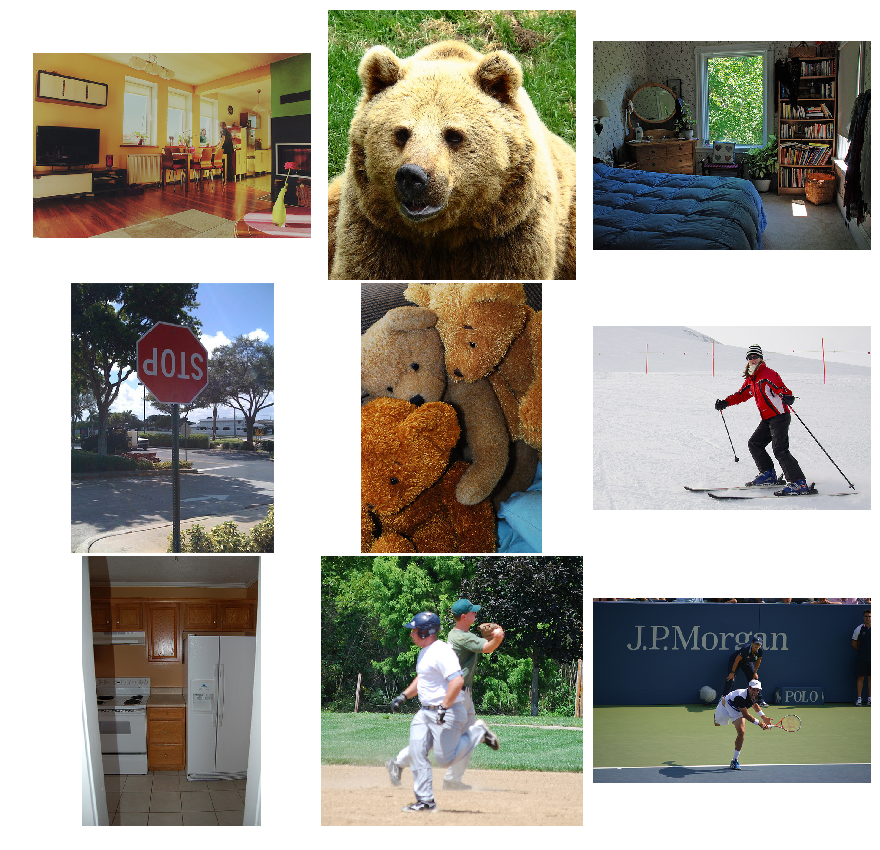

In [154]:
# scan the first nine raw images in the dataset
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
fig.subplots_adjust(wspace = .01, hspace = 0.01)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(Raw_images[i][:,:,::-1])
    ax.axis("off")       
#fig.savefig('initial.png')

Select images that only contains humans with visible labeled keypoints